# Author validation

A machine learning model that identifies whether or not the claimed author of some content is the original. 
We're going to use reddit comments, fetched from r/cryptocurrency for our train/test dataset.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /home/ken/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We're going to load our datasets into a pandas dataframe first.

In [2]:
data_dir = "~/Datasets/reddit-rcryptocurrency/"
datasets = {"%s%s.csv" % (data_dir, t) for t in ["2017-11", "2017-12", "2018-01", "2018-02", "2018-03"]}
dt_cols = {"author": str, "body": str, "created_utc": str}
df = pd.concat([pd.read_csv(dataset, usecols=dt_cols, dtype=dt_cols) for dataset in datasets], ignore_index=True)

Let's get some insights from our dataset.

In [3]:
df = df.dropna()
df.count()

author         2160613
body           2160613
created_utc    2160613
dtype: int64

We have more than 2 million reddit comments.

In [4]:
df.head(n=10)

,author,body,created_utc
0,patientzero_,what is taxable then in your opinion?,1519862403
1,FreeSpeechWarrior,This post got censored,1519862404
2,heresmyusername,NEO = gud,1519862405
3,longbreaks,Selling at ATH = His average price is damn nea...,1519862406
4,916hotdogs,[removed],1519862408
5,havllis,"Offcourse everyone on DarkWeb using Macintosh,...",1519862409
6,Poozy,Holly shit ICX is killing me,1519862415
7,porkchop487,The company that partnered with them had Vital...,1519862424
8,vGrizzly,And this is enough for me to never own any WTC...,1519862425
9,cryptocrazy55,"Also, why do they have themselves in there 18 ...",1519862429


Some of the text contains links, some authors are deleted, let's dive a little deeper on the texts first.

In [5]:
for txt in list(df["body"][:100]):
    print(txt)
    print("-----------------")

what is taxable then in your opinion?
-----------------
This post got censored
-----------------
NEO = gud
-----------------
Selling at ATH = His average price is damn near where LTC is hovering right now.

Shilling the shit out of = questioning trade offs for fast and free transactions, and saying the tech is cool.

Noted. I don't think it's betrayal at all. You'd be stupid think Bill Gates or Steve Jobs never said anything nice about the other, even if it wasn't public.
-----------------
[removed]
-----------------
Offcourse everyone on DarkWeb using Macintosh, Bill said.
-----------------
Holly shit ICX is killing me
-----------------
The company that partnered with them had Vitalik's endorsement so people believed that it meant Vitalik endorsed them himself. Unless you have a source of V saying that Vitalik partnered with them
-----------------
And this is enough for me to never own any WTC ever again, good job!
-----------------
Also, why do they have themselves in there 18 times?

At this point I'm going to remove text with too few and too much words. But what does 'too few' and 'too much' mean? We can make a plot and inspect the number of words per text along with the number of characters.

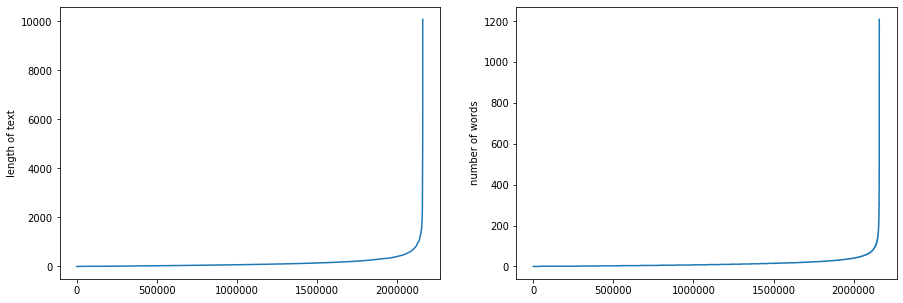

In [6]:
def words_num(txt):
     return len([x for x in txt.split() if 3 < len(x) < 30])

def plot_chars_and_words():
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.plot(list(df["body"].apply(len).sort_values()))
    plt.ylabel("length of text")

    plt.subplot(122)
    plt.plot(list(df["body"].apply(lambda txt: words_num(txt)).sort_values()))
    plt.ylabel("number of words")

    plt.show()

plot_chars_and_words()

In [7]:
conf_min_chars = 150
conf_max_chars = 2000
conf_min_words = 20
conf_max_words = 300

condition = lambda txt: conf_max_chars > len(txt) > conf_min_chars and conf_max_words > words_num(txt) > conf_min_words
df = df[df["body"].map(condition)]
df.count()

author         461045
body           461045
created_utc    461045
dtype: int64

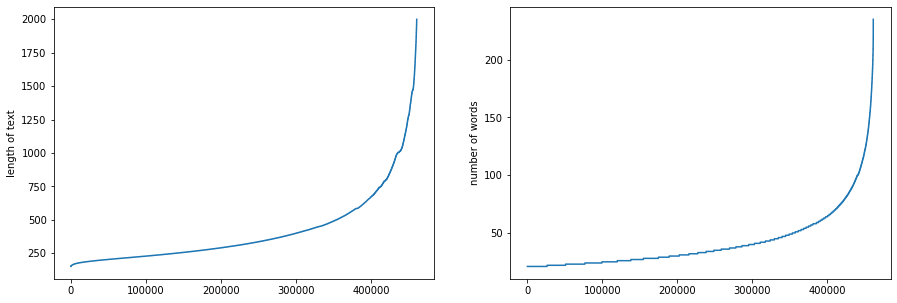

In [8]:
plot_chars_and_words()

At this point we removed very large and very small comments, but we still have comments from authors that aren't writing frequently so we aren't really confident on their writing style and identifying them yet. We're going to keep authors with a certain ammount of comments.

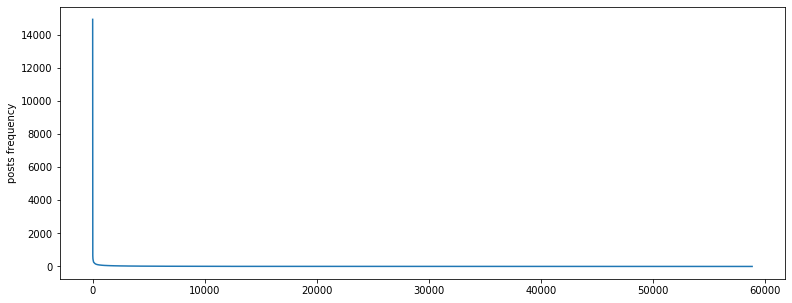

In [9]:
def plot_posts_frequency():
    plt.figure(figsize=(13, 5))
    plt.plot(df["author"].value_counts().to_list())
    plt.ylabel("posts frequency")
    plt.show()

plot_posts_frequency()

We should keep authors with a frequency near the curve in the above diagram.

In [10]:
conf_min_posts_num = 200
conf_max_posts_num = 1000
df = df[df.groupby("author")["author"].transform("size") > conf_min_posts_num]
df = df[df.groupby("author")["author"].transform("size") < conf_max_posts_num]
"Total authors:", df["author"].nunique()

('Total authors:', 155)

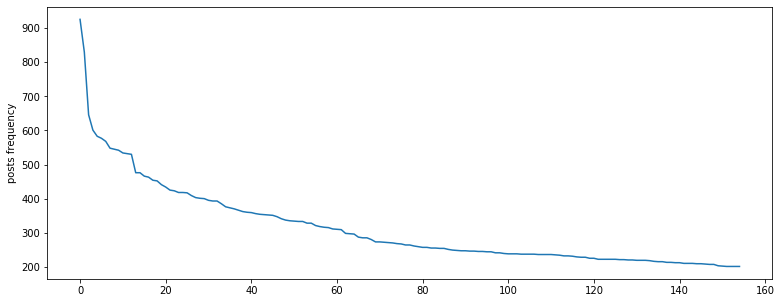

In [11]:
plot_posts_frequency()

Now we can clean our texts by applying stemming, lemmatization and lowercase conversion.

In [12]:
conf_apply_stemming = True
conf_apply_lemmatizing = True
conf_to_lower_case = True

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lem = nltk.stem.wordnet.WordNetLemmatizer()
stem = nltk.stem.porter.PorterStemmer()

def tokenize(text):
    res = ""
    for w in w_tokenizer.tokenize(text):
        if conf_apply_lemmatizing:
            w = lem.lemmatize(w)
        if conf_apply_stemming:
            w = stem.stem(w)
        if conf_to_lower_case:
            w = w.lower()
        res += w + " "
    return res.strip()

df["optimized_body"] = df["body"].apply(tokenize)

In [13]:
# pick a target author and train a model to recognize what he wrote
df["author"]

17         InspectorCollector
22                  Suuperdad
109        InspectorCollector
138                    simmol
155                      Gsw-
                  ...        
2160357     aSchizophrenicCat
2160381            stablecoin
2160545        Mr_SpicyWeiner
2160612        DeepFriedOprah
2160621     CanadianCryptoGuy
Name: author, Length: 48534, dtype: object

And now let's train a model for a random author

In [14]:
# pick target author and add a new column which indicates whether or not he is the target author.
# this is the column that we're going to try to predict.
target_author = "simmol"
df["is_target"] = df["author"]==target_author
df.head()

,author,body,created_utc,optimized_body,is_target
17,InspectorCollector,Thats what i'm hoping for. It seems a strong p...,1519862448,that what i'm hope for. it seem a strong platf...,False
22,Suuperdad,I insta sold. Entire stack. Fuck that shit.\n\...,1519862462,i insta sold. entir stack. fuck that shit. eve...,False
109,InspectorCollector,Deepest apologies. I thought the added specifi...,1519862847,deepest apologies. i thought the ad specif of ...,False
138,simmol,"But in this market, it is not just about funda...",1519862966,"but in thi market, it is not just about fundam...",True
155,Gsw-,Heavy bags? It's already started recovering si...,1519863033,heavi bags? it' alreadi start recov sinc it we...,False


In [15]:
df["is_target"].value_counts()

False    47888
True       646
Name: is_target, dtype: int64

It's clear that we have much more False values against True. We want to have a balance in our dataset so we're going to keep an ammount of False close to the number of True. We can achieve that by sampling the dataset.

In [16]:
sdf = pd.concat([df[df["is_target"] == True], df[df["is_target"] == False].sample(n=400)])
sdf = sdf.sample(frac=1).reset_index(drop=True) # random shuffle
sdf.head()

,author,body,created_utc,optimized_body,is_target
0,Mr0ldy,That is definitely a possibility. After watchi...,1514497300,that is definit a possibility. after watch the...,False
1,simmol,For those of you who think that ICX is recover...,1517396799,for those of you who think that icx is recover...,True
2,simmol,I really think ENG is going to do well the nex...,1516765572,i realli think eng is go to do well the next f...,True
3,simmol,I really am not sure how to get in here. It s...,1519824013,i realli am not sure how to get in here. it se...,True
4,opus_dota,Do you have accounts at huobi or bibox or crpy...,1519496429,do you have account at huobi or bibox or crpyt...,False


Now let's move forward to vectorizing the corpus. Since computers perform better with numbers we have to convert our corpus to a machine-friendly format.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

conf_max_df=.80
conf_min_df=0.01
conf_n_gram_range=(1,3)
conf_remove_stop_words=False

vectorizer = TfidfVectorizer(
    max_df=conf_max_df,
    min_df=conf_min_df,
    ngram_range=conf_n_gram_range,
    stop_words="english" if conf_remove_stop_words else None,
    token_pattern=r'(?u)\b[A-Za-z0-9]+\b'
)

vectors = vectorizer.fit_transform(sdf["optimized_body"])
vectors.shape

(1046, 1505)

Let's split our dataset to train/test

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    vectors,
    sdf["is_target"],
    test_size=0.20,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((836, 1505), (210, 1505), (836,), (210,))

We're going to try 3 different classifiers (SGD, SVM, Bayesian)

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

classifier = SGDClassifier(
    loss="log",
    penalty="l1",
    max_iter=15,
    n_jobs=-1,
    random_state=42
)

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions, target_names=["0", "1"]))

0.9238095238095239
[[ 71  12]
 [  4 123]]
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        83
           1       0.91      0.97      0.94       127

    accuracy                           0.92       210
   macro avg       0.93      0.91      0.92       210
weighted avg       0.93      0.92      0.92       210



In [20]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(tol=1e-8, max_iter=10000)

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions, target_names=["0", "1"]))

0.9285714285714286
[[ 70  13]
 [  2 125]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90        83
           1       0.91      0.98      0.94       127

    accuracy                           0.93       210
   macro avg       0.94      0.91      0.92       210
weighted avg       0.93      0.93      0.93       210



In [21]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

classifier.fit(X_train.toarray(), y_train)
predictions = classifier.predict(X_test.toarray())

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions, target_names=["0", "1"]))

0.8428571428571429
[[ 63  20]
 [ 13 114]]
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        83
           1       0.85      0.90      0.87       127

    accuracy                           0.84       210
   macro avg       0.84      0.83      0.83       210
weighted avg       0.84      0.84      0.84       210



SVM and SGD perform slightly better than bayesian. We're going to pick SVM because SGD requires larger datasets to converge.

Let's collect the average results for every author.

In [22]:
y_true = np.array([])
y_pred = np.array([])

for target_author, _ in df["author"].value_counts().items():
    classifier = LinearSVC(tol=1e-9, max_iter=1000000)
    
    df["is_target"] = df["author"]==target_author
    dft = df[df["is_target"] == True]    
    dff = df[df["is_target"] == False].sample(n=dft.shape[0])
    sdf = pd.concat([dft, dff])
    sdf = sdf.sample(frac=1).reset_index(drop=True) # random shuffle
    
    vectors = vectorizer.fit_transform(sdf["optimized_body"])
    X_train, X_test, y_train, y_test = train_test_split(
        vectors,
        sdf["is_target"],
        test_size=0.20,
        random_state=42
    )
    classifier.fit(X_train.toarray(), y_train)
    predictions = classifier.predict(X_test.toarray())

    y_true = np.append(y_true, y_test)
    y_pred = np.append(y_pred, predictions)
    
print(accuracy_score(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["0", "1"]))

0.831185500847153
[[8117 1641]
 [1647 8072]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      9758
           1       0.83      0.83      0.83      9719

    accuracy                           0.83     19477
   macro avg       0.83      0.83      0.83     19477
weighted avg       0.83      0.83      0.83     19477

